In [2]:
import coexist
import pandas as pd
from tifffile import imread
import os
from scipy.stats import zscore, spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from tqdm import tqdm
from decimal import Decimal
import numpy as np
from sklearn.mixture import GaussianMixture

In [ ]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])
    
def check_thresholds(model, thresholds):
    mean_low = min(model.means_[0][0], model.means_[1][0])
    mean_high = max(model.means_[0][0], model.means_[1][0])
    if mean_low < thresholds[0] < mean_high:
        t = thresholds[0]
    elif mean_low < thresholds[1] < mean_high:
        t = thresholds[1]
    else:
        t = None
        print('Fail')
    return t

In [3]:
c = 'B4'
slide_1_table = pd.read_csv(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_mIHC.csv')
slide_2_table = pd.read_csv(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_cyCIF.csv')
slide_1 = imread(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_mIHC.tif')
slide_2 = imread(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_cyCIF.tif')
shared_dict = {'DSDNA':'DNA_1',
               'CD3':'CD3',
               'PDL1':'PDL1',
               'GRZB':'GRZB',
               'FOXP3':'FOXP3',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD20':'CD20',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}

In [4]:
matcher = coexist.model.COEXIST(im1_mask=slide_1,
                               im2_mask=slide_2,
                               df1 = slide_1_table,
                               df2 = slide_2_table,
                               cellID_key = 'CellID',
                               shared_markers=shared_dict,
                               method='coexist',
                               diameter_key='MajorAxisLength',
                               mpp1=0.5,
                               mpp2=0.65,
                               thickness=5)

In [ ]:
matcher.preprocess_data()

Computing cost matrix


In [ ]:
matcher.match_cells()

In [ ]:
matcher.check_correlations()

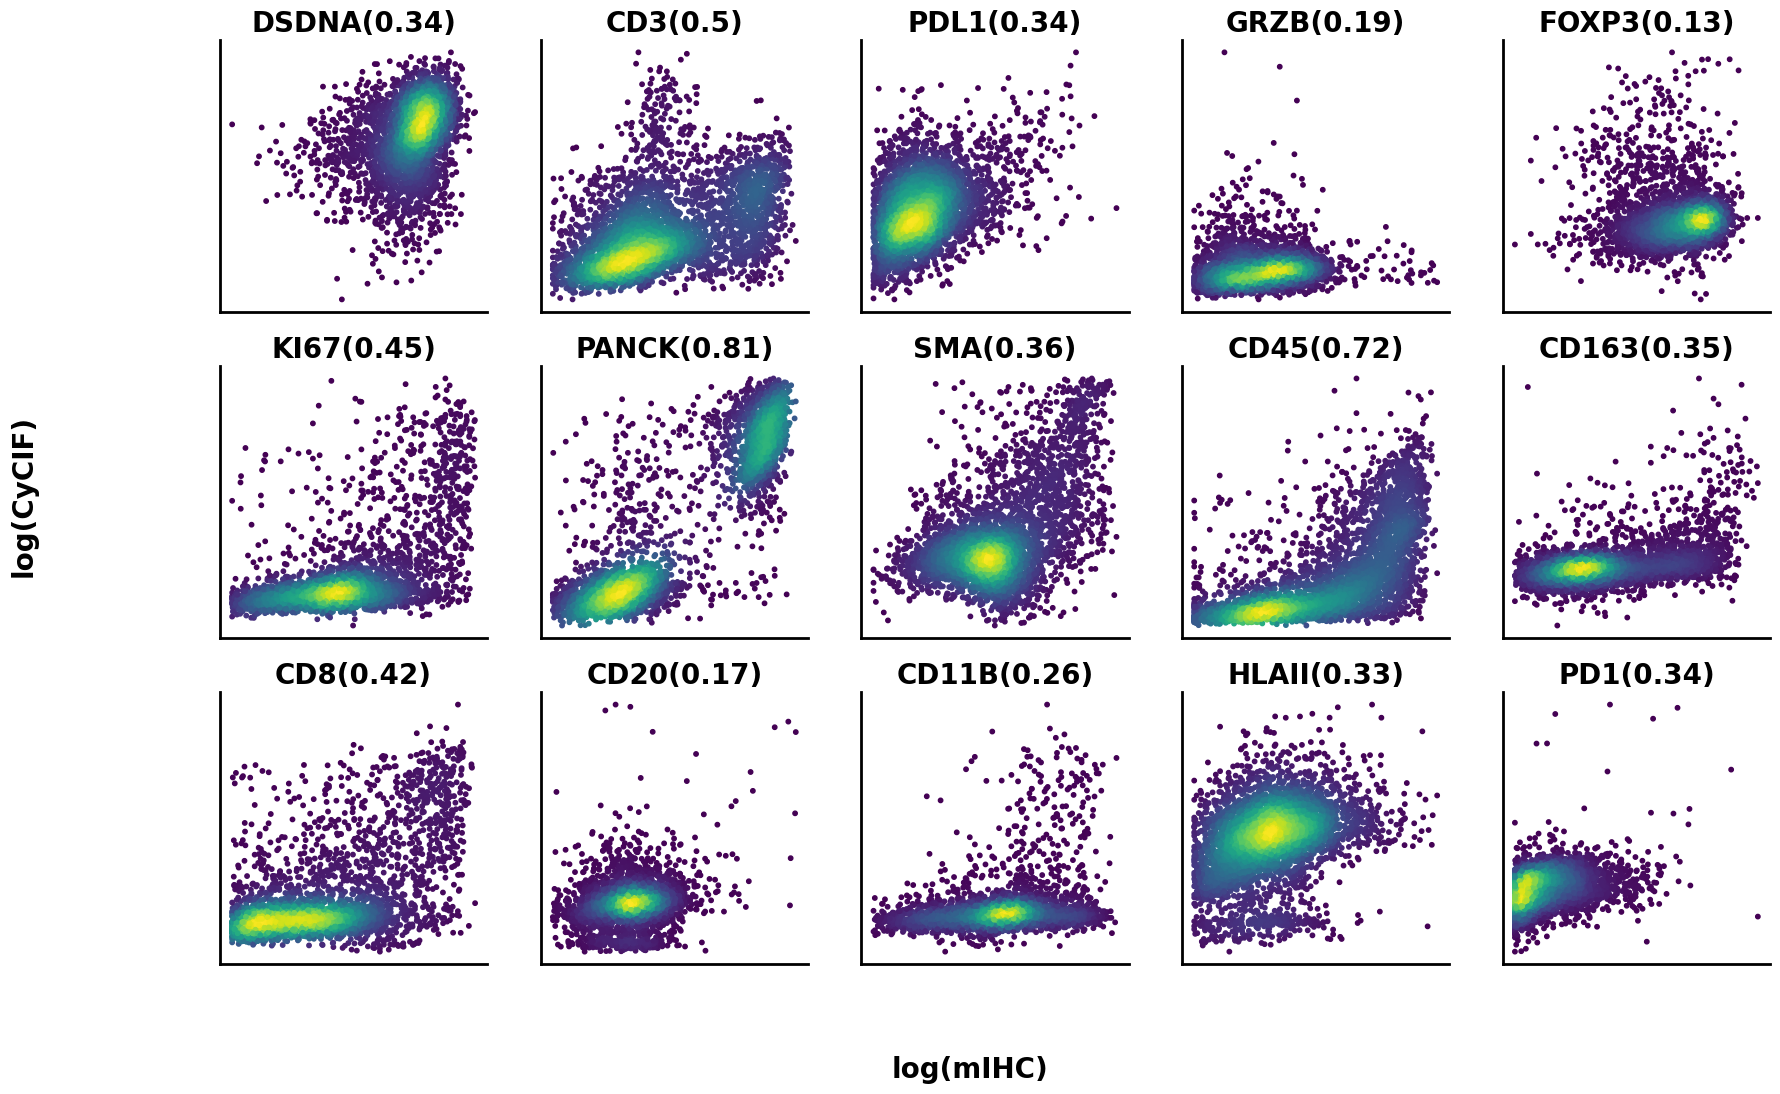

In [62]:
fig, ax = plt.subplots(3,5,figsize=(20,12))
ax = ax.flatten()
shared_dict = {'DSDNA':'DNA_1',
               'CD3':'CD3',
               'PDL1':'PDL1',
               'GRZB':'GRZB',
               'FOXP3':'FOXP3',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD20':'CD20',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+matcher.df1_matched[m1])
    f2 = np.log(1+matcher.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1}({sp})',fontsize=20, weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
fig.supxlabel('log(mIHC)',fontsize=20, weight='bold')
fig.supylabel('log(CyCIF)',fontsize=20, weight='bold')
#fig.tight_layout()
fig.show()

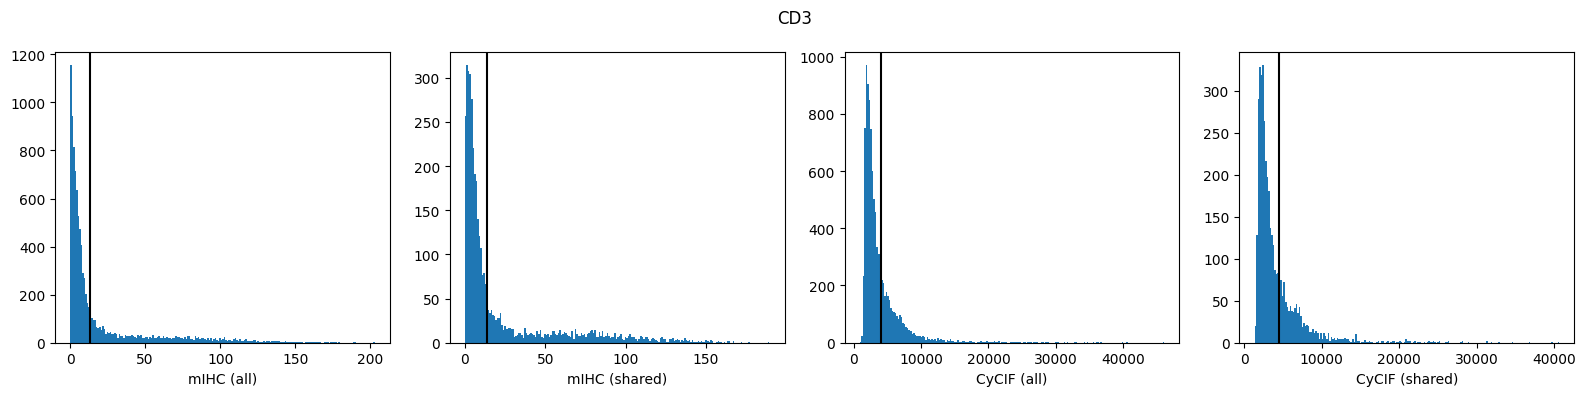

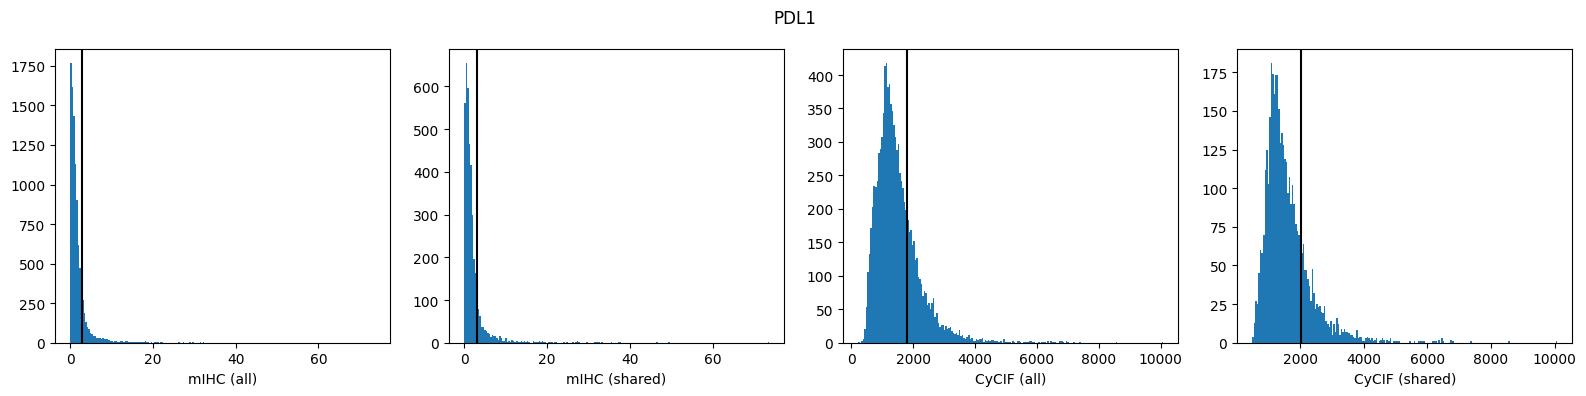

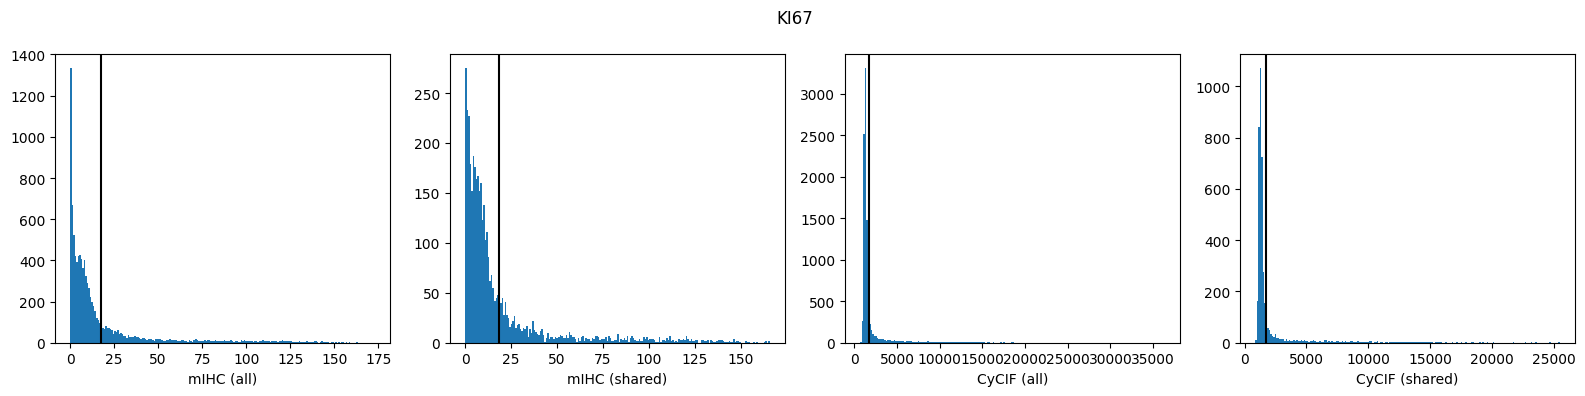

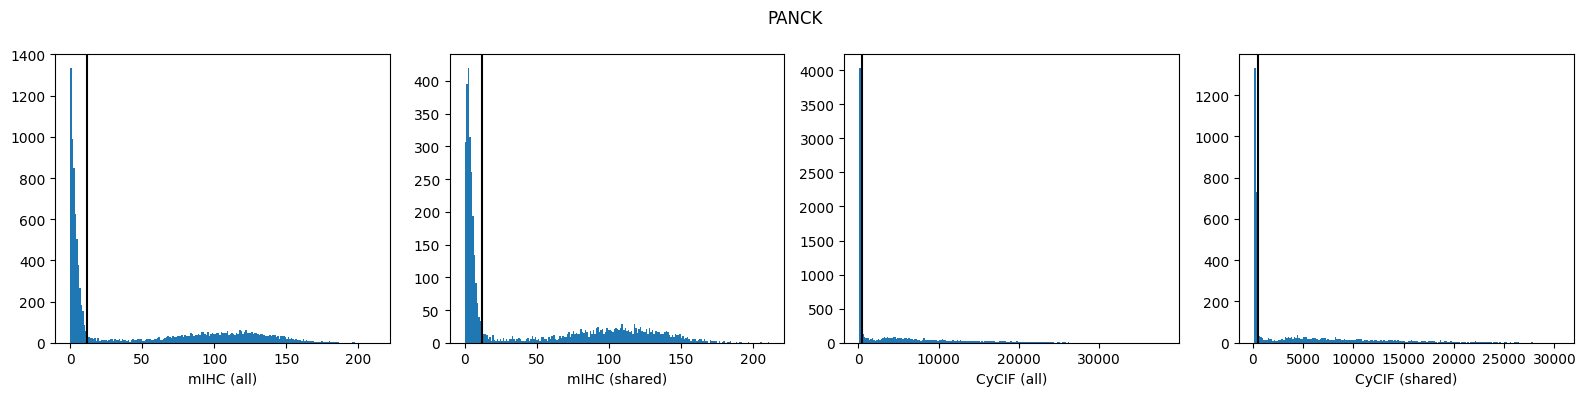

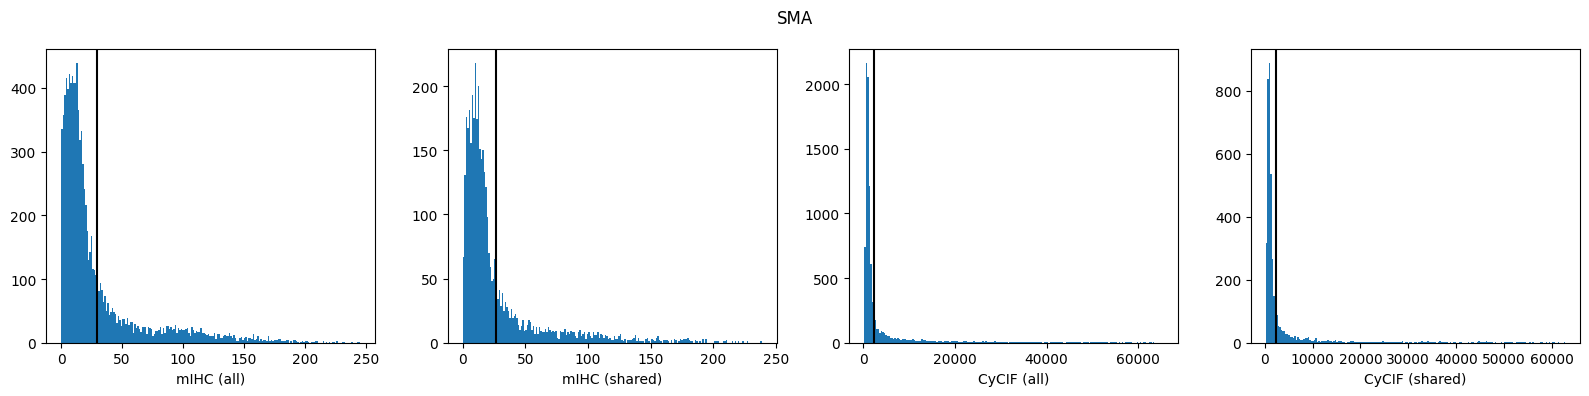

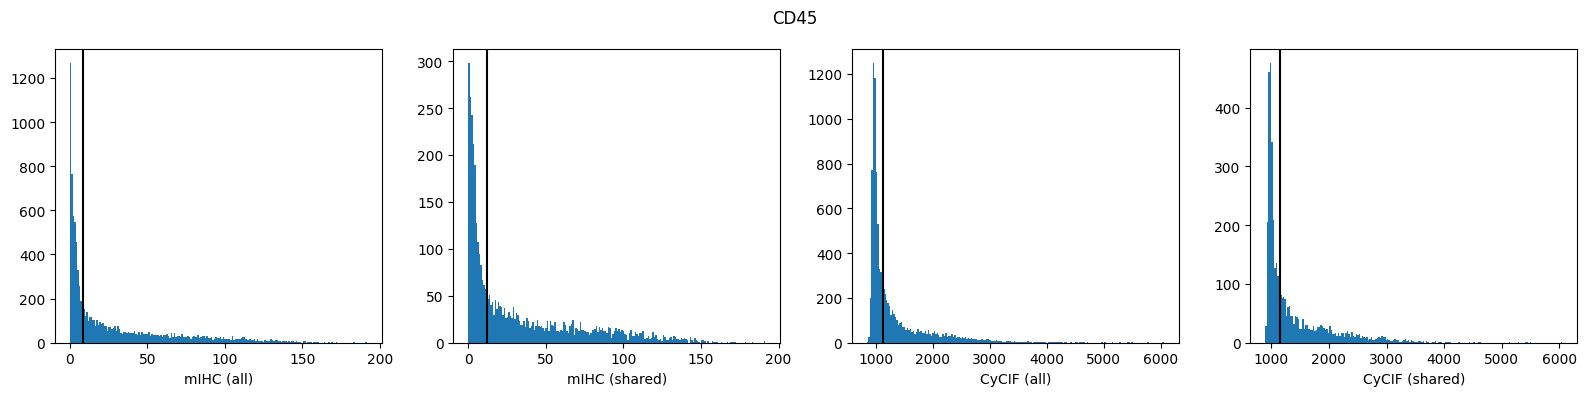

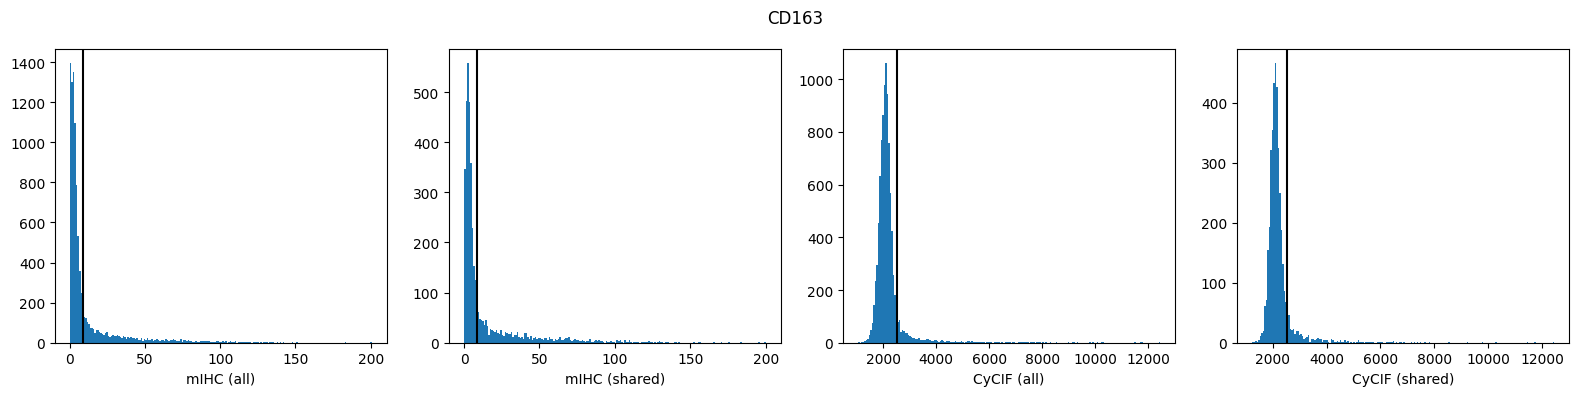

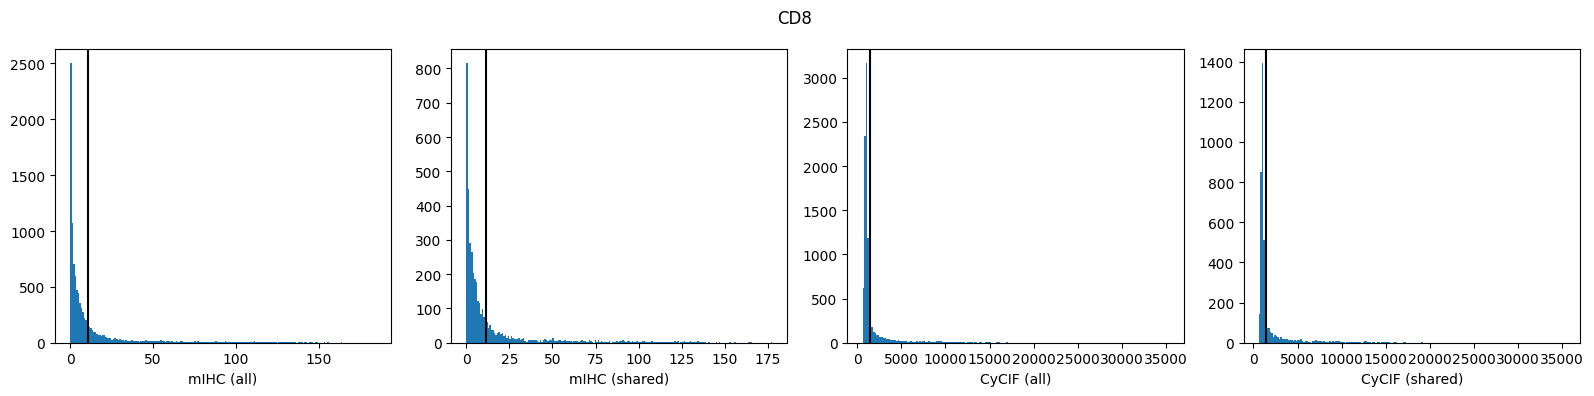

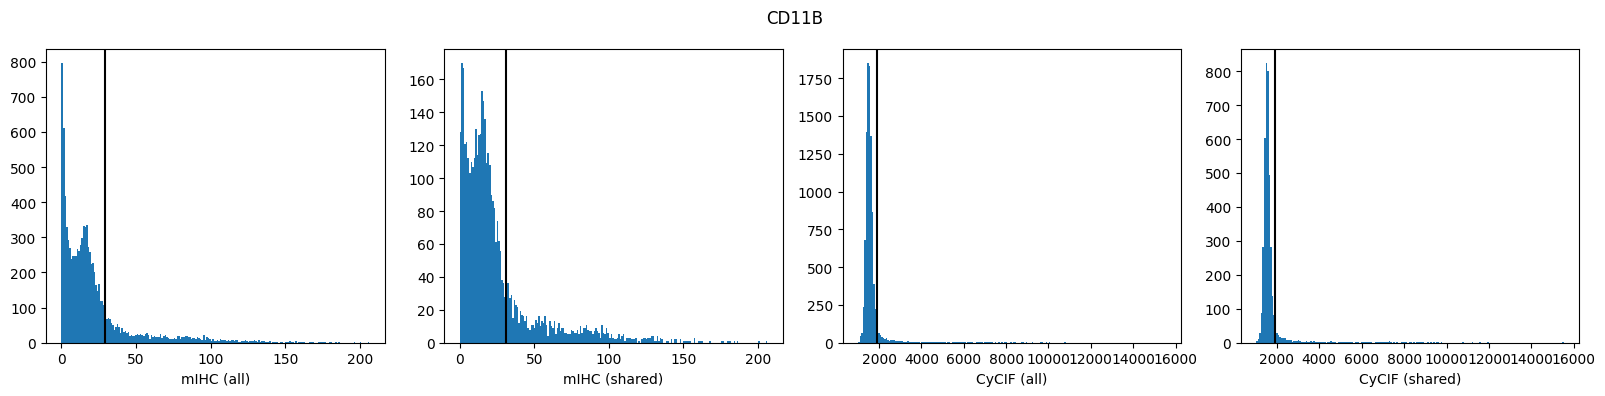

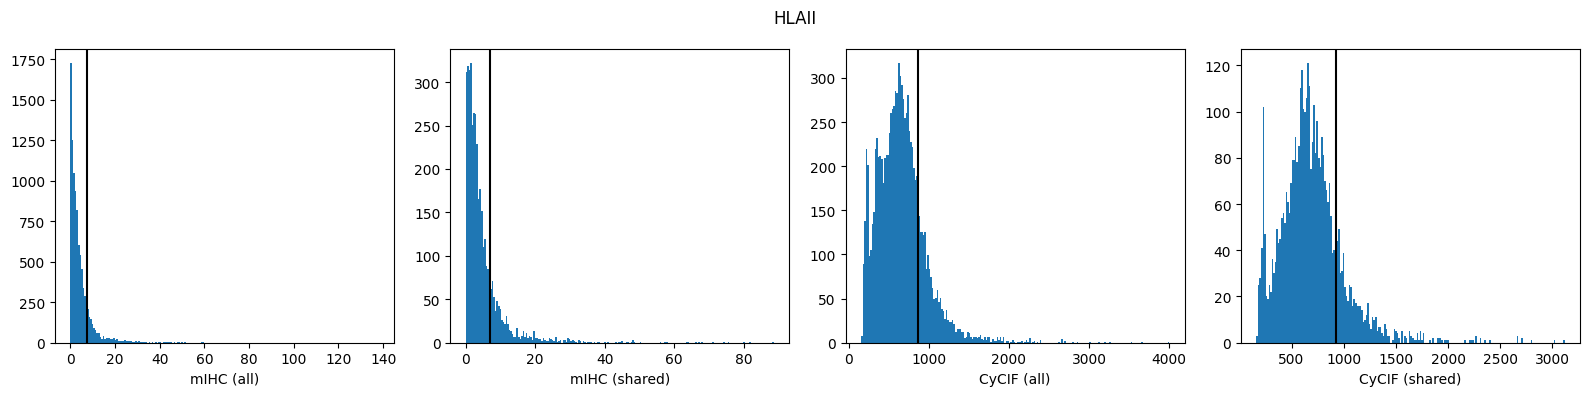

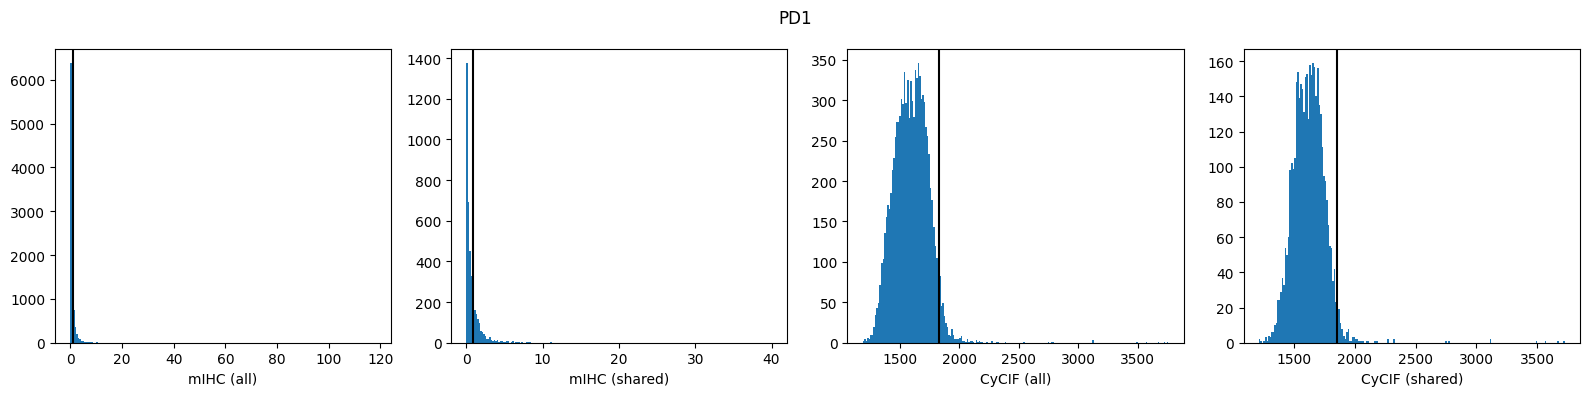

In [63]:
shared_dict = {'CD3':'CD3',
               'PDL1':'PDL1',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}

slide_1_all = []
slide_1_shared = []
slide_2_all = []
slide_2_shared = []
mIHC_thresholds = []
CyCIF_thresholds = []

for m1,m2 in shared_dict.items():
    fig, ax = plt.subplots(1,4,figsize=(16,4))
    fig.suptitle(m1)
    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(slide_1_table[m1]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    table = slide_1_table.copy()
    slide_1_all.append(len(table[table[m1]>t])/len(table))
    ax[0].hist(table[m1],bins=200)
    ax[0].axvline(t,color='black',zorder=1)
    ax[0].set_xlabel('mIHC (all)')

    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(matcher.df1_matched[m1]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    mIHC_thresholds.append(t)
    table = matcher.df1_matched.copy()
    slide_1_shared.append(len(table[table[m1]>t])/len(table))
    ax[1].hist(table[m1],bins=200)
    ax[1].axvline(t,color='black',zorder=1)
    ax[1].set_xlabel('mIHC (shared)')

    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(matcher.df2_matched[m2]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    CyCIF_thresholds.append(t)
    table = matcher.df2_matched.copy()
    slide_2_shared.append(len(table[table[m2]>t])/len(table))
    ax[3].hist(table[m2],bins=200)
    ax[3].axvline(t,color='black',zorder=1)
    ax[3].set_xlabel('CyCIF (shared)')
    
    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(slide_2_table[m2]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    table = slide_2_table.copy()
    slide_2_all.append(len(table[table[m2]>t])/len(table))
    ax[2].hist(table[m2],bins=200)
    ax[2].axvline(t,color='black',zorder=1)
    ax[2].set_xlabel('CyCIF (all)')
    plt.tight_layout()
    plt.show()

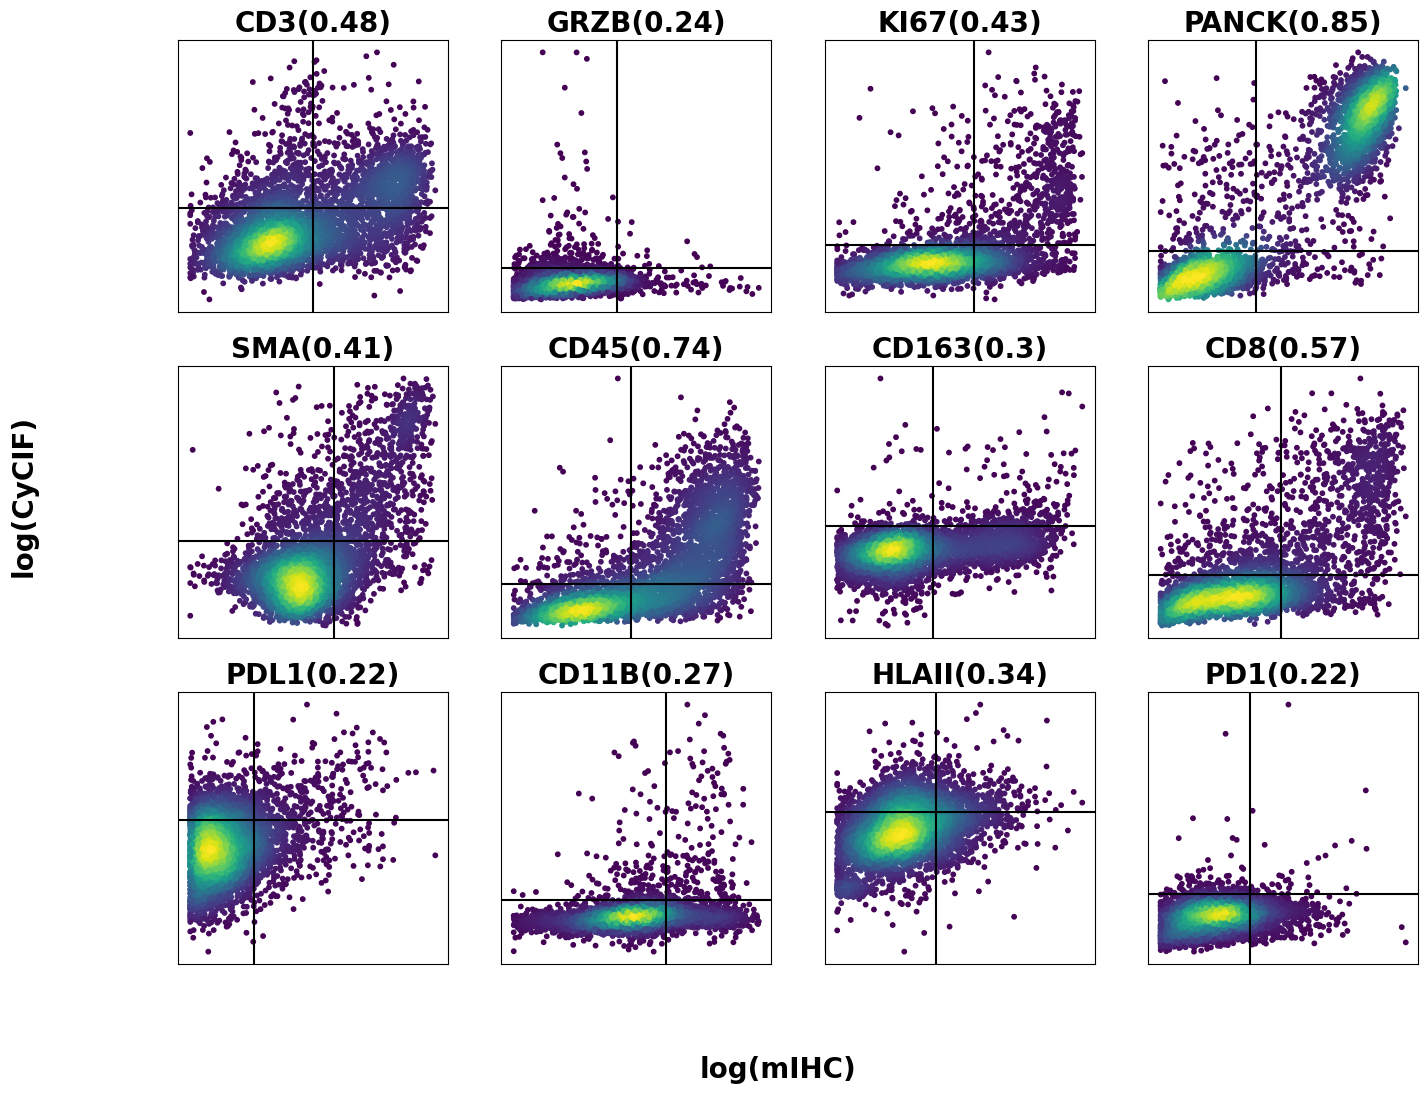

In [54]:
fig, ax = plt.subplots(3,4,figsize=(16,12))
ax = ax.flatten()
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+matcher.df1_matched[m1])
    f2 = np.log(1+matcher.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1}({sp})',fontsize=20, weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    #for axis in ['top','bottom','left','right']:
    #    ax[i].spines[axis].set_linewidth(2)
    #ax[i].spines['top'].set_visible(False)
    #ax[i].spines['right'].set_visible(False)
    ax[i].axvline(np.log(1+mIHC_thresholds[i]),color='black')
    ax[i].axhline(np.log(1+CyCIF_thresholds[i]),color='black')
fig.supxlabel('log(mIHC)',fontsize=20, weight='bold')
fig.supylabel('log(CyCIF)',fontsize=20, weight='bold')
#fig.tight_layout()
fig.show()

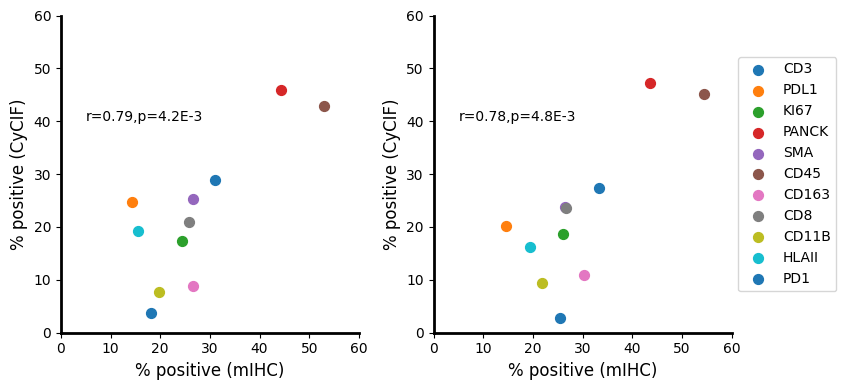

In [64]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
for i, (m1,m2) in enumerate(shared_dict.items()):
    ax[0].scatter(slide_1_all[i]*100, slide_2_all[i]*100, zorder=1, label=m1, s=50)
    ax[1].scatter(slide_1_shared[i]*100, slide_2_shared[i]*100, zorder=1, label=m1, s=50)

ax[0].set_xlabel('% positive (mIHC)',fontsize=12)
ax[0].set_ylabel('% positive (CyCIF)',fontsize=12)
ax[0].text(5,40,f'r={np.round(pearsonr(slide_1_all, slide_2_all)[0],2)},p={Decimal(str(pearsonr(slide_1_all, slide_2_all)[1])):.1E}')
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,60])

ax[1].set_xlabel('% positive (mIHC)',fontsize=12)
ax[1].set_ylabel('% positive (CyCIF)',fontsize=12)
ax[1].text(5,40,f'r={np.round(pearsonr(slide_1_shared, slide_2_shared)[0],2)},p={Decimal(str(pearsonr(slide_1_shared, slide_2_shared)[1])):.1E}')
ax[1].set_xlim([0,60])
ax[1].set_ylim([0,60])
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()